In [20]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [21]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [22]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [23]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [24]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with = engine, reflect = True)

In [25]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [26]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [27]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [28]:
# Read and print data from measurement table
data = pd.read_sql("SELECT * FROM Measurement", conn)
data.tail()

,id,station,date,prcp,tobs
19545,19546,USC00516128,2017-08-19,0.09,71.0
19546,19547,USC00516128,2017-08-20,NaN,78.0
19547,19548,USC00516128,2017-08-21,0.56,76.0
19548,19549,USC00516128,2017-08-22,0.50,76.0
19549,19550,USC00516128,2017-08-23,0.45,76.0


# Exploratory Precipitation Analysis

In [50]:
# Defining a function to convert input dates into datetime object
def date_converter(date):
    
    date_str = str(date).strip()
    date_dt = datetime.strptime(date_str, '%Y-%m-%d').date()

    return date_dt

In [51]:
# Find the most recent date in the data set.
recent_date_query = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date_query

('2017-08-23',)

In [53]:
# Taking the most recent data value out of the tuple, and turning it into a datetime value
recent_date = recent_date_query[0]
date = date_converter(recent_date)
recent_date

'2017-08-23'

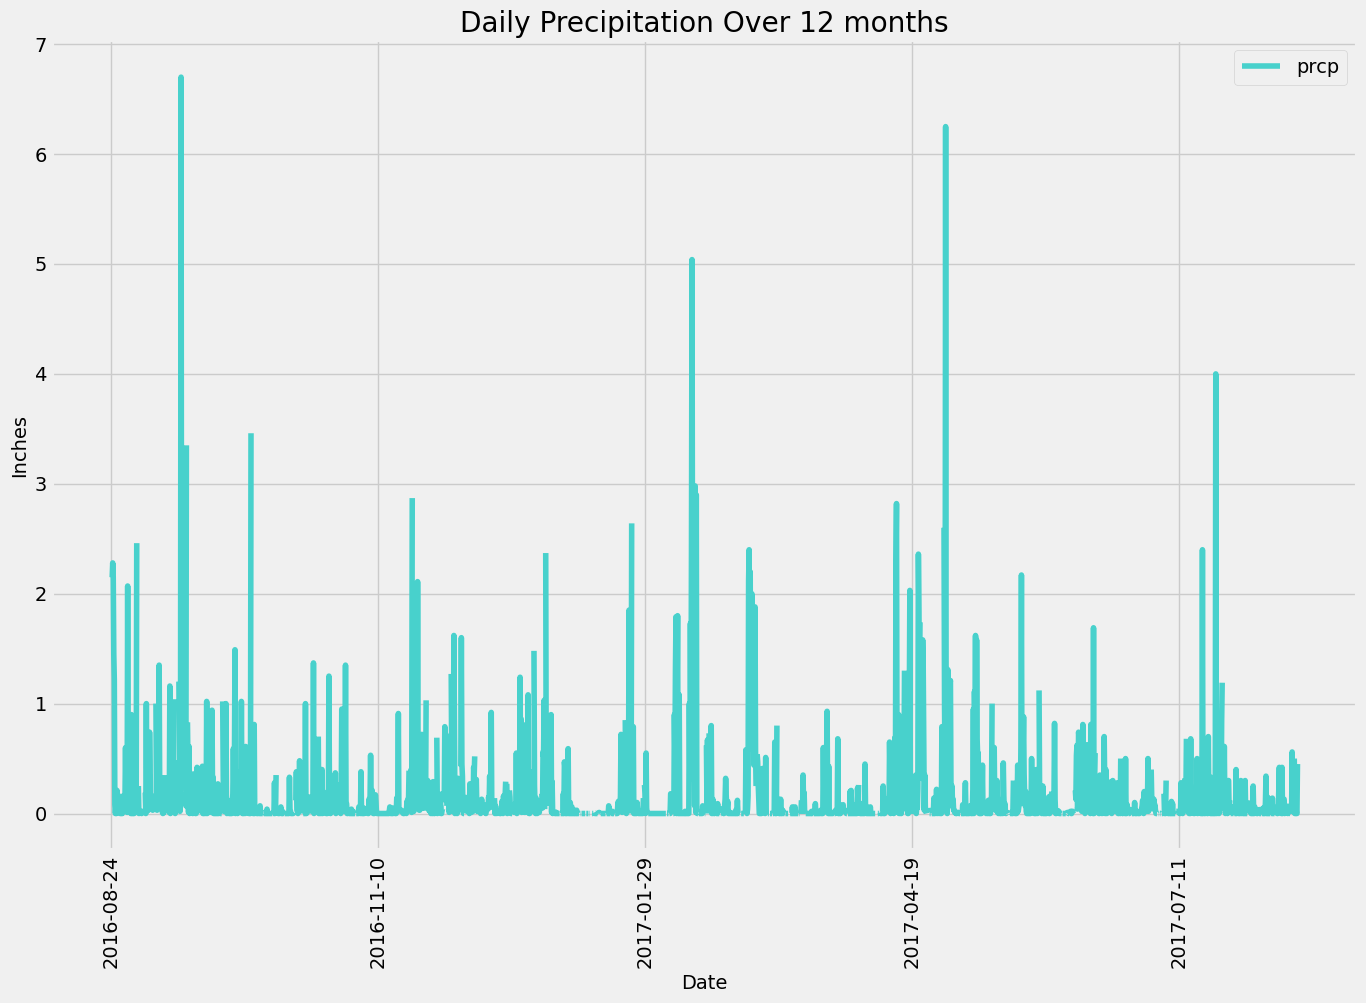

In [55]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
recent_date = dt.datetime.strptime(recent_date, "%Y-%m-%d")
#print(recent_date)

# Calculate the date one year previous from the last date in data set.
prev_year = recent_date - dt.timedelta(days=365)
prev_year = prev_year.date()

# Perform a query to retrieve the data and precipitation scores
prcp_query = session.query(Measurement.date, Measurement.prcp)\
                    .filter(Measurement.date > prev_year).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(prcp_query, columns = ['Date', 'prcp'])
prcp_df

# Sort the dataframe by date
prcp_df = prcp_df.sort_values('Date')
prcp_df

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(x='Date', y='prcp', kind='line',\
       figsize=(15,10),title = 'Daily Precipitation Over 12 months',\
       ylabel='Inches',legend=True,rot=90,color="mediumturquoise")

plt.show()

In [56]:
# Use Pandas to calculate the summary for the precipitation data.
prcp_stats = prcp_df['prcp'].describe()

# Convert the summary in a DataFrame
prcp_stats = pd.DataFrame(prcp_stats)
prcp_stats

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [ ]:
# Design a query to calculate the total number of stations in the dataset
session.query(Station).count()

In [ ]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station))\
.group_by(Measurement.station)\
.order_by(func.count(Measurement.station).desc()).all()

active_stations

In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
avg_temp = session.query(Measurement.station,\
              func.max(Measurement.tobs),\
              func.min(Measurement.tobs),\
              func.avg(Measurement.tobs))\
.filter(Measurement.station == 'USC00519281').all()

avg_temp

In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_obs = session.query(Measurement.date, Measurement.tobs)\
.filter(Measurement.station == 'USC00519281').filter(Measurement.date > prev_year).all()
temp_obs
#temp_obs = dt.datetime.strptime(emp_obs, '%Y-%m-%d')
#session.query(Measurement.tobs).filter(Measurement.date > recent_date).all()
tobs_df = pd.DataFrame(temp_obs, columns=['Date', 'Temperature'])
tobs_df.plot.hist(bins=12, color='coral')
plt.savefig('Resources/Temp_Graph.png')



# Close Session

In [ ]:
session.close()

In [60]:
# Dependecies
from concurrent.futures import ProcessPoolExecutor
from flask import Flask, jsonify

# Design Flask API
app = Flask(__name__)
# Flask routes

@app.route("/")
def homepage():
    return (
        f"Available Routes:<br/>"
        f"/api/v1.0/precipitation<br/>"
        f"/api/v1.0/stations<br/>"
        f"/api/v1.0/tobs<br/>"
        f"/api/v1.0/[start date]<br/>"
        f"/api/v1.0/[start date]/[end date]<br/>" )

@app.route("/api/v1.0/precipitation")
def precipitation():
    """Return the last 12 months of precipitation data"""

    # Perform a query to retrieve the data and precipitation scores and sort queries by date
    date_prcp = session.query(Measurement.date, Measurement.prcp).\
    order_by(Measurement.date).\
    filter(Measurement.date>=year_ago).all()
    
    # Making a dictionary where date is the key and prcp is the value
    date_prcp_dict={}
    for date, prcp in date_prcp:
        date_prcp_dict[date]=prcp
        
    #jsonify dictionary
    return jsonify(date_prcp_dict)


@app.route("/api/v1.0/stations")
def stations():
    """Return a list of all stations"""

    # retrieve all 9 stations
    stations_query = session.query(Station.station).all()

    # open the tuples to return a list
    stations_list = list(np.ravel(stations_query))

    #jsonify list
    return jsonify(stations_list)

@app.route("/api/v1.0/tobs")
def tobs():
    """Return a list of temperatures of the most active station in the last year"""

    #query to find the most active station
    most_active_station_query = session.query(Measurement.station).\
                   group_by(Measurement.station).\
                   order_by(func.count(Measurement.station).desc()).first()

    most_active_station = most_active_station_query[0]

    # query to retrieve temperature data for most active station
    active_temp = session.query(Measurement.tobs).filter(Measurement.station == most_active_station).\
              filter(Measurement.date>=year_ago).all()
    
    # turning query into list
    active_temp_list = list(np.ravel(active_temp))

    # return jsonified list
    return jsonify(active_temp_list)


@app.route("/api/v1.0/<start>")
def start_temp(start):
    """Retrieve the minimum temperature, average temperature and average temperature for all dates greater than the start date."""

    # converting input start date into datetime object
    date_dt = date_converter(start)

    # query to find min, avg and max temperature for dates after start date
    temp_query = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= date_dt).all()
    
    # turn query into list
    temp_list = list(np.ravel(temp_query))

    #if statement to check if the list is empty or not
    if temp_list[0] == None:
        return jsonify({"error": f"The date {date_dt} is not in range."}), 404

    else:
        #return jsonified list
        return jsonify(temp_list)
    
@app.route("/api/v1.0/<start>/<end>")
def start_end_temp(start, end):
    """Retrieve the minimum temperature, average temperature and average temperature for range of dates given."""

    # converting input start and end dates into datetime objects
    start_date_dt = date_converter(start)
    end_date_dt = date_converter(end)

    # Check if end date is greater than start date
    if end_date_dt >= start_date_dt:
        
        # query to find min, avg and max temperature for dates after start date
        temp_query = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
            filter(Measurement.date >= start_date_dt).filter(Measurement.date <= end_date_dt).all()
        
        # turn query into list
        temp_list = list(np.ravel(temp_query))

        #if statement to check if the list is empty or not
        if temp_list[0] == None:
            return jsonify({"error": f"{start_date_dt} - {end_date_dt} is not in range."}), 404

        else:
            #return jsonified list
            return jsonify(temp_list)


    else:
    
        return jsonify({"error": f"The start date {start_date_dt} is after the end date {end_date_dt}."}), 404


if __name__ == "__main__":
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with watchdog (fsevents)
Traceback (most recent call last):
  File "/Users/denicia/anaconda3/envs/PythonData/lib/python3.10/site-packages/ipykernel_launcher.py", line 15, in <module>
    from ipykernel import kernelapp as app
  File "/Users/denicia/anaconda3/envs/PythonData/lib/python3.10/site-packages/ipykernel/__init__.py", line 5, in <module>
    from .connect import *  # noqa
  File "/Users/denicia/anaconda3/envs/PythonData/lib/python3.10/site-packages/ipykernel/connect.py", line 11, in <module>
    import jupyter_client
  File "/Users/denicia/anaconda3/envs/PythonData/lib/python3.10/site-packages/jupyter_client/__init__.py", line 8, in <module>
    from .asynchronous import AsyncKernelClient  # noqa
  File "/Users/denicia/anaconda3/envs/PythonData/lib/python3.10/site-packages/jupyter_client/asynchronous/__init__.py", line 1, in <module>
    from .client import AsyncKernelClient  # noqa
  File "/Users/denicia/an

SystemExit: 1

/Users/denicia/anaconda3/envs/PythonData/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3468: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
